In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from datetime import date, datetime


sns.set_style("darkgrid")

In [3]:
ticker = "CL=F"
interval = "1d"
start_date = datetime.strptime("2017-01-01", "%Y-%m-%d")
end_date = date.today()

# WTI Crude.
raw_df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"), interval=interval)
raw_df.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,54.200001,55.240002,52.110001,52.330002,52.330002,727793
2017-01-04,52.490002,53.430000,52.150002,53.259998,53.259998,512641


In [4]:
raw_df.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-03,75.919998,78.000000,73.099998,73.389999,73.389999,413414
2023-02-06,73.230003,74.510002,72.250000,74.110001,74.110001,413414


In [67]:
df = pd.DataFrame()
df["price"] = raw_df[["Adj Close"]]
df["bmonth_end"] = df.index + pd.offsets.BMonthEnd(0)



# TODO: consider if Saturday is included by the `pd.offsets.BMonthEnd(0)`.
# If not, do:
#   Last DAY of the month that is not a Sunday (day 6).
df["day_of_week"] = df.index.day_of_week
df["day_of_month"] = df.index.day

df["day_of_week"].describe()

count    1537.000000
mean        2.024073
std         1.399895
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: day_of_week, dtype: float64

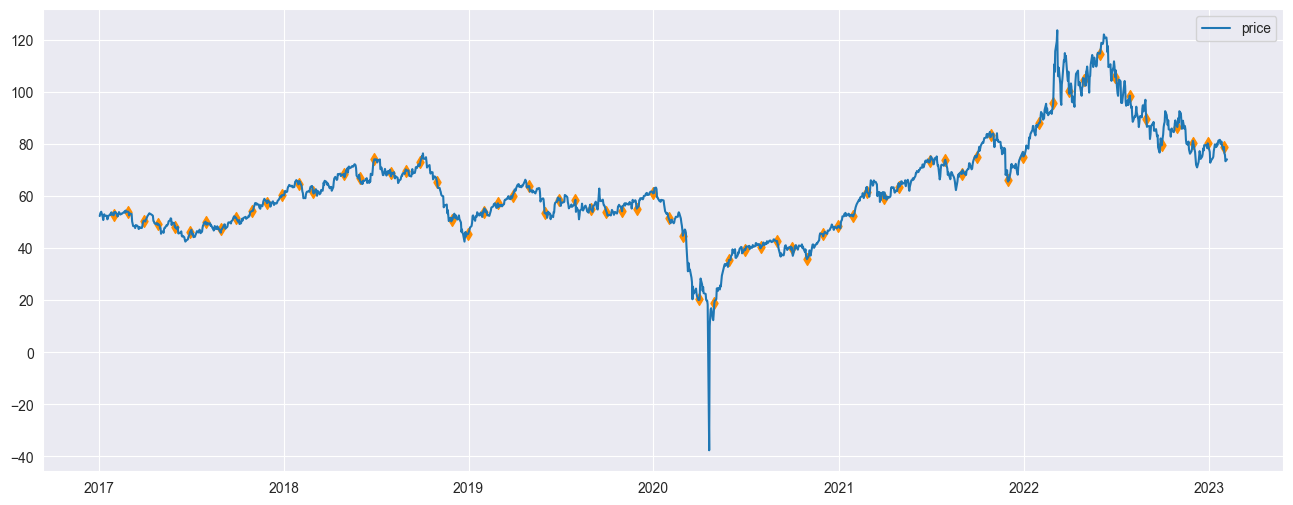

In [59]:
fig = plt.figure()
fig.set_size_inches(16, 6)

b = df.query("is_bmonth_end")

plt.plot(df["price"], label="price")
plt.scatter(b.index, b["price"], marker="d", color="darkorange")

# for index in b.index:
    # plt.axvline(index, color="orange", linestyle="dotted")

plt.legend()
plt.show()